# Ensemble Global Shapley Values
#### PGE 383 Subsurface Machine Learning
##### Abraham Montes-Humanez
##### The University of Texas at Austin
-------------------------------------------

### 1. Background

### 2. Packages Import

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import math

### 3. Data Loading and Initial Exploration

The data corresponds to the depth-based drilling parameters in the well 58-32 of Utah FORGE, published at <a href="https://gdr.openei.org/submissions/1113">Utah FORGE Repo</a> <br>

Podgorney, Robert, McLennan, John, & Moore, Joe. Utah FORGE: Drilling Data for Student Competition. United States. https://dx.doi.org/10.15121/1495411

Suppose we want to build a map to be used by the driller to maximize efficiency and thus, drill faster. To do this, and keeping interpretability and visualization as a key priority, we will limit the number of predictor variables to 3. How to select the 3 most important ones? Let's investigate... <br>

The predictors are the following: 
<ol>
    <li>rop: Rate of penetration (ft/h)</li>
    <li>depth: Well depth (ft)</li>
    <li>rpm: Rotation speed (rev/min)</li>
    <li>gpm: Flow rate (gal/min)</li>
    <li>wob: Weight on bit (klb)</li>
    <li>temp_out: Mud temperature at the Flow line (degF)</li>
</ol>

In [68]:
df = pd.read_csv('Well_5832_data.csv')

In [69]:
df.describe()

,depth,rop,wob,temp_out,rpm,gpm
count,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000
mean,3835.043935,42.010324,23.116699,126.059506,54.947292,716.254127
std,2147.503980,75.921118,9.119495,12.259879,25.947654,141.784179
min,85.180000,0.000000,0.000000,84.070000,0.000000,0.000000
25%,1970.395000,11.400000,18.310000,116.130000,38.090000,620.260000
50%,3851.850000,17.990000,23.830000,124.860000,50.380000,700.210000
75%,5691.585000,44.295000,29.680000,136.490000,75.965000,824.610000
max,7536.250000,2977.910000,47.050000,151.700000,271.580000,3317.510000


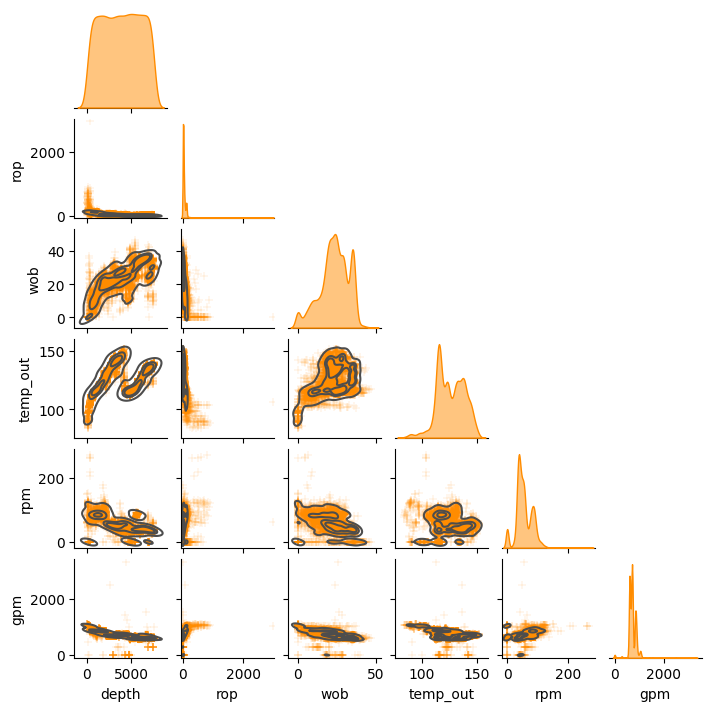

In [77]:
g=sb.pairplot(
    df,diag_kind = "kde", 
    plot_kws=dict(marker="+", linewidth=0.1, c='darkorange'),
    diag_kws=dict(color='darkorange',alpha=0.5), height=1.2, corner=True,
)

g.map_lower(sb.kdeplot, levels=4, color=".3");

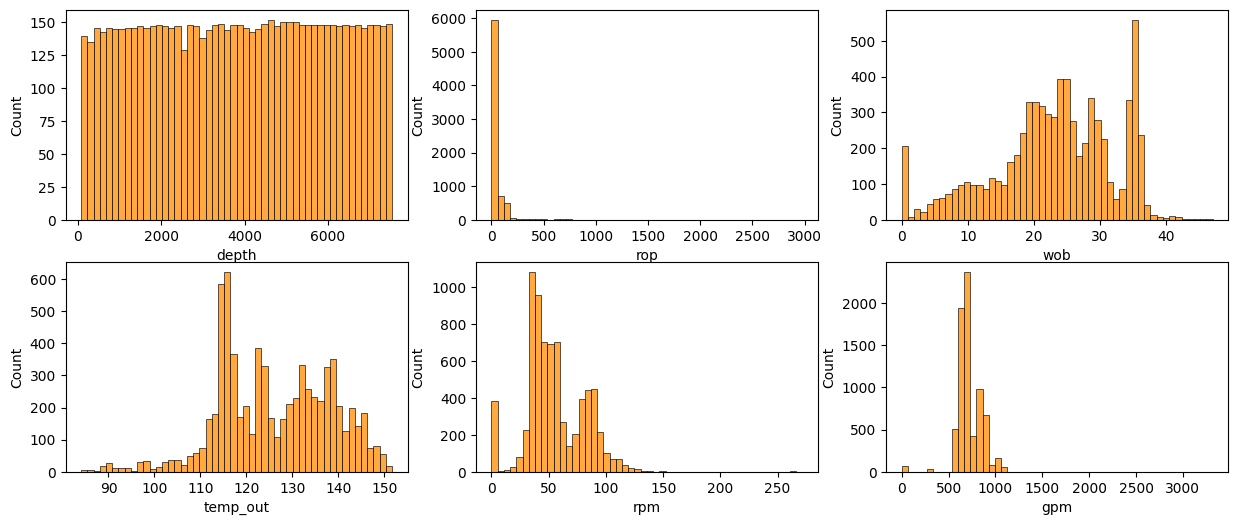

In [71]:
fig,axs=plt.subplots(2,3,figsize=(15,6))
for i,col in enumerate(df.columns):
    sb.histplot(data=df, bins=50, x=col, log_scale=False, color='darkorange', ax=axs[i//3,i%3]);

Some observations from the univariate distributions: 
<ul>
<li>ROP (the response) has a heavy tail that drags the expectation far away from the median. In drilling, this may be the result of 2 conditions: 1) Decallibration of the ROP due to missing zeroing of the WOB, and 2) True abnormaly soft intervals that can be drilled even without applying WOB. Since the number of samples is low for the abnormaly high values of the response (lack of coverage), we can experiment the likewise deletion of these instances</li> <br>
<li>The flow rate (GPM) also shows a very thin righ tail. This is 100% caused by wrong readings from the SPM sensor. The pumps capacity is way below 2000 gpm. We will clean these outliers out, placing the cuttoff at 1500 gpm, from the pumps capacity</li> <br>
<li>The rotation speed (rpm) has the same situation as Flow rate. We will cap this variable at 160 rpm, which is a normal capacity for 1500HP top drives</li><br>
<li>We are also not interested in depths shallower than 300 ft, because this typically corresponds to cleaning of conductor pipe, instad of drilling consolidated rock</li><br>
<li>Finally, what we see in the bivariate between temperature out and depth is very interesting. It reflects the fact that we are dealing with 2 different sections. Once the casing is lowered and cemented, a large amount of friction is faded out</li><br>
</ul>

### 4. Data Preprocessing

In [75]:
df_pp = df.copy(deep=True)
df_pp=df_pp[(df_pp['gpm']<1500) & (df_pp['rpm']<160) & (df_pp['rop']<300) & (df_pp['depth']>300)]
df_pp.describe()

,depth,rop,wob,temp_out,rpm,gpm
count,7085.000000,7085.000000,7085.000000,7085.000000,7085.000000,7085.000000
mean,3948.485565,33.988799,23.785163,127.007836,54.901193,705.710487
std,2081.533534,36.613092,8.370860,11.150699,24.023562,125.198258
min,300.580000,0.000000,0.000000,101.300000,0.000000,0.000000
25%,2138.970000,11.260000,18.850000,116.440000,38.270000,619.390000
50%,3963.230000,17.390000,24.070000,125.780000,50.380000,698.440000
75%,5747.860000,41.040000,29.870000,136.800000,75.460000,745.750000
max,7536.250000,297.680000,47.050000,151.700000,146.030000,1417.550000


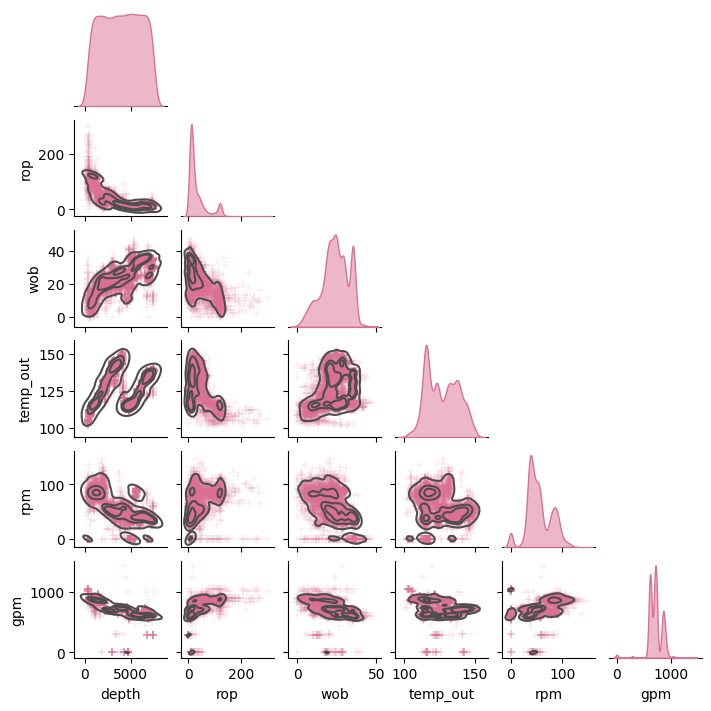

In [78]:
g=sb.pairplot(
    df_pp,diag_kind = "kde", 
    plot_kws=dict(marker="+", linewidth=0.1, c='palevioletred'),
    diag_kws=dict(color='palevioletred', alpha=0.5), height=1.2, corner=True,
)

g.map_lower(sb.kdeplot, levels=4, color=".3");

In [82]:
#Feature Standardization
from sklearn.preprocessing import StandardScaler

df_n = df_pp.copy(deep=True)
scaler = StandardScaler()
cols = df_n.columns
df_n=scaler.fit_transform(df_n.values)
df_n = pd.DataFrame(df_n, columns=cols)
df_n.describe()

,depth,rop,wob,temp_out,rpm,gpm
count,7085.000000,7.085000e+03,7.085000e+03,7.085000e+03,7.085000e+03,7.085000e+03
mean,0.000000,-6.418452e-17,-1.283690e-16,8.985833e-16,6.418452e-17,3.851071e-16
std,1.000071,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-1.752632,-9.283892e-01,-2.841624e+00,-2.305654e+00,-2.285467e+00,-5.637141e+00
25%,-0.869380,-6.208272e-01,-5.896062e-01,-9.477955e-01,-6.923356e-01,-6.895190e-01
50%,0.007084,-4.533889e-01,3.402961e-02,-1.101207e-01,-1.882115e-01,-5.807589e-02
75%,0.864508,1.926005e-01,7.269583e-01,8.782279e-01,8.558372e-01,3.198314e-01
max,1.723738,7.202610e+00,2.779461e+00,2.214561e+00,3.793577e+00,5.686100e+00


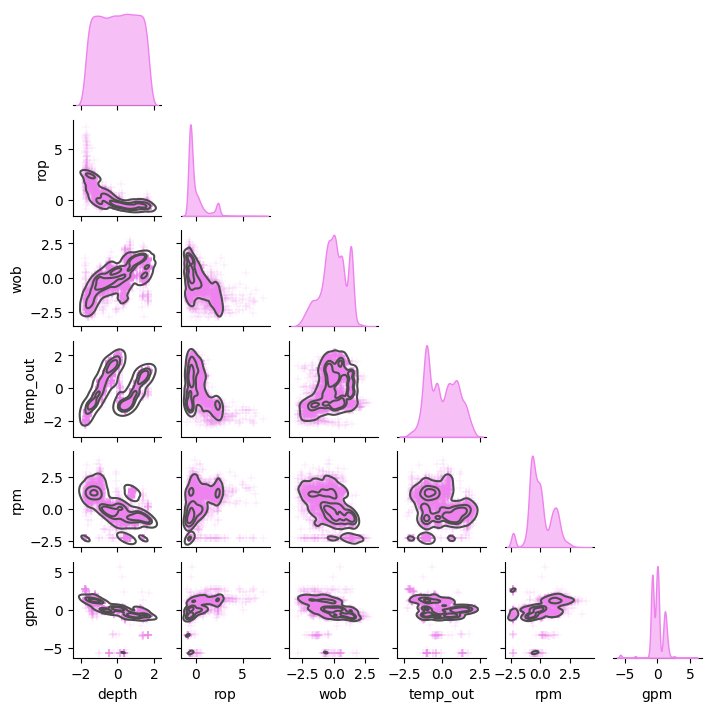

In [83]:
g=sb.pairplot(
    df_n,diag_kind = "kde", 
    plot_kws=dict(marker="+", linewidth=0.1, c='violet'),
    diag_kws=dict(color='violet', alpha=0.5), height=1.2, corner=True,
)

g.map_lower(sb.kdeplot, levels=4, color=".3");

### 5. Ensemble Creation

### 6. Ensemble Shapley Values

### 7. Analysis and Conclusions

### 8. References